# Code to run UE solver processes:

### Introduction

This UE Solver takes an origin-destination demand input (origin, destination, number of cars taking this path) and a road network and assigns a path for each trip such that **no traveler can decrease travel time by shifting to a new path.** 
* * *
The solver is finding the [static user equilibrium](https://en.wikipedia.org/wiki/Route_assignment#Equilibrium_assignment) network flows. The travel time per road segment (link) is assumed to be a function of the link's flow/capacity and is set according to the Bureau of Public Roads (BPR) link congestion function: 
$$TT_a = TT_{a,free-flow} \left( {1 + 0.15\left( {\frac{{v_a }}
{{c_a }}} \right)^4 } \right)$$
where $TT_a$ = Average Travel time on link a; $ TT_{free-flow}$ = Free flow travel time on link a; $v_a$ = volume of traffic on link a per unit of time (somewhat more accurately: flow attempting to use link a); and $c_a$ = capacity of link a per unit of time. 


* * *

In addition to finding the network static user equilibrium network flows, this UE Solver package has several methods to simulate alternative road networks. Reasons for altering the road network include increasing/decreasing road capacity, simulating road closures, floods, or any sort of disruption in the original road network. 

Processing the results will convert the assigned travel to a geojson file. In addition, processing results can calculate VMT, VHT, and delay.

* * *
### Notes
These instructions assume that a pre-step has been done to generate a networkx graph of the network.
It is also assumed that we have converted the graph to a geojson and added appropriate extra fields (like city, county, etc.) 

If this is not the case - these steps can be completed in the "Converting networkx into geojson (only has to be done once)" cell [below](#convertingtogeojson) <a href = "#convertingtogeojson"> </a>.

To run the solver, we require the following inputs:
* Networkx graph
* Demand file grouped by some partitions of an area (i.e. TAZ, city, county, district, etc)
    * Demand file should have three columns: origin, destination, and flow
* Shapefile corresponding to the above demand file

The UE Solver implementaion is not my own - this package primarily facilitates network modification and pre-processing, result processing, and includes a python wrapper that runs [Matthew Steele's Equilibrium Solver](http://www.repsilat.com/EquilibriumSolver.html). 

* * *
###Example input files
All files needed to run the solver for the Bay Area can be found here: https://paper.dropbox.com/doc/Bay-Area-UE-Solver-resources-W9SLplNM8J3ljws9VFZaF.

# Using the solver

### 1. Modifying the network (optional)
* [Update network capacity](#network-capacity)
<a href = "#network-capacity"> </a>
* [Cut links](#cut-links)
<a href = "cut-links"></a>

### 2. Run solver [here](#run-solver)
<a href = "#run-solver"></a>

### 3. Process results [here](#process-results)
<a href = "#process-results"></a>

<a id = "convertingtogeojson"> </a>
# Converting networkx into geojson (only has to be done once)
If geojson exists for the network of interest, then should not need to run this cell.

In [ ]:
from ue_solver.conversions import networkx_to_geojson
from ue_solver.modify_network import remove_duplicate_links
from ue_solver.modify_network import label_road_network, append_city_names

#inputs:
graph_f='resources/network/sf_secondary/network_graph.txt'
geojson_f ='resources/network/sf_secondary/network.geojson' 

networkx_to_geojson(graph_f, geojson_outf=geojson_f)

# if this is the first time creating a geojson from a networkx, probably want to 
# run the following clean-up:
remove_duplicate_links(geojson_inf=geojson_f, geojson_outf=geojson_f)

#to add city (and county) info:
ca_cities_shp = 'resources/shapefiles/ca_cities_2014'
label_road_network(ca_cities_shp, geojson_f, ['CityType','County','NAME'], geojson_f, ['city_type', 'county', 'city'])

<a id="network-capacity"> </a>
# Modifying network: 
## 1. Update network capacity:
* Simulate different capacities in network
* Requires geoJSON format of networkx graph (can be obtained from conversion in the above cell)

In [ ]:
from ue_solver.modify_network import update_capacity

attr_dict = {'county': ['Alameda']}
# attr_dict = {'city': ['Berkeley', 'Oakland']}
percent_cap = .5
geojson_inf = 'resources/network/sf_secondary/network.geojson'
geojson_outf = 'resources/network/sf_secondary_alameda_0p5/network.geojson'
graph_outf = 'resources/network/sf_secondary_alameda_0p5/network_graph.txt'

update_capacity(attr_dict, percent_cap, geojson_inf, 
                geojson_outf, graph_outf)

<a id = "cut-links"> </a>
## 2. Cut links:
* Simulate network with links removed
* Cut links is a CSV file of links that will be removed (to simulate road closures, etc)
* **Note on formatting**:
    * CSV file should have 2 columns, OSM init and OSM terminal (from Open Street Maps)

In [ ]:
from ue_solver.modify_network import cut_links

#Inputs:
geojson_inf = 'resources/network/sf_secondary/network.geojson'
links_f = 'resources/cut_links/berkeley_cut_links.csv'
geojson_outf = 'resources/network/sf_secondary_cutlinks/network.geojson'
graph_outf = 'resources/network/sf_secondary_cutlinks/network_graph.txt'

cut_links(geojson_inf, links_f, geojson_outf, graph_outf)

<a id = "run-solver"> </a>
# Run solver

In [1]:
from ue_solver import run_solver

taz_demand_f = 'resources/demand/TAZ_sf_demand.csv'
network_graph = 'resources/network/sf_secondary/network_graph.txt'
output_file = 'resources/results/sf_secondary/demand_1p5_gap50.txt'

run_solver.run_solver_full(network_graph, taz_demand_f, output_file, 
                           taz_shapefile='resources/shapefiles/Travel_Analysis_Zones/',
                           demand_scale = 1.5, distance_factor=0, toll_factor=0, 
                           gap = 40.0)


started at 1494303077.43
Running FW algorithm
done in 532.453516006 sec


<a id = "process-results"></a>
# Process results
* Now that the results have been generated from "Run solver", we can analyze VMT (Vehicle Miles Traveled), VHT (Vehicle Hours Traveled), and Delay (difference from free flow time)
* The geojson file can be uploaded into QGIS to visualize results.

## 1. Results to geojson

In [2]:
from ue_solver.process_results import results_to_geojson

#Inputs:
results_f = 'resources/results/sf_secondary/demand_1p5_gap40.txt'
geojson_inf = 'resources/network/sf_secondary/network.geojson'
geojson_outf = 'resources/results/sf_secondary/demand_1p5_gap40.geojson'

results_to_geojson(results_f, geojson_inf, geojson_outf)

## 2. VMT, VHT, Delay
Takes the results calculated from solver and sums miles, hours and delay for each trip to calculate vehicle miles traveled, vehicle hours traveled and delay respectively.

Vehical miles traveled and vehicle hours traveled are calculated by multiplying flow across a link by the length and time traveled respectively. 
Delay is calculated by taking the difference between result travel time and free flow travel time.


In [2]:
from ue_solver.process_results import geoj_vmt_vht_delay
from ue_solver.process_results import get_total_demand
import time


start = time.time()
print('started at', start)

results_geoj = 'resources/results/sf_secondary/demand_1p5_gap40.geojson'

demand_f = 'resources/demand/TAZ_sf_demand.csv'
totalODflow = get_total_demand(demand_f, demand_scale=1.5)
min_speed = 0
cities_aggregate_output_file = 'resources/results/sf_secondary/vmt_vht_delay_cities.csv'
output_summary = 'resources/results/sf_secondary/vmt_vht_delay_summary.csv'
city_plots_save_path = 'resources/results/sf_secondary/city_vmt_vht_delay_plots.pdf'

geoj_vmt_vht_delay(results_geoj, cities_aggregate_output_file, output_summary, totalODflow, min_speed, 
                   city_plots_save_path)

print('done in', time.time()-start, 'sec')

('started at', 1494304604.833278)
totalvmt: 15038082.6951
totalvht: 600146.347694
totaldelay: 254296.354967
vmt per traveler: 9.72724620557
vht per traveler: 0.388199174175
delay per traveler: 0.164489270614
('done in', 24.300251007080078, 'sec')


/Users/madeleinesheehan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Network visualization
We recommend using [QGIS](http://www.qgis.org/en/site/) to view the network and visualize the results. QGIS is a free/open source Geographical Information System (GIS) software. Download QGIS on your coumputer and then drag and drop a .geojson file into the QGIS program to see the network. 

###Visualizing results:
[This QGIS layer style](https://www.dropbox.com/s/4g2wyjno7cf0d24/ue_congestion_style.qml?dl=0) can be loaded in QGIS to visualize the congestion in the network. The layer style colors the links according to congestion ((realized travel time)/(free flow travel time)); the street width is set proportional to road capacity. See example image from the Bay Area results created in QGIS below


<img src="https://goo.gl/KK1OXu" alt="Drawing" style="width: 500px;"/>

###Note 
It's also possible to view the road network using geopandas to download the geojson file (as below), but the process is quite slow for large networks. We recommend using QGIS. The colors in the map below have no significance, but you could probably assign colors to the road network following some examples here: http://geopandas.org/mapping.html.

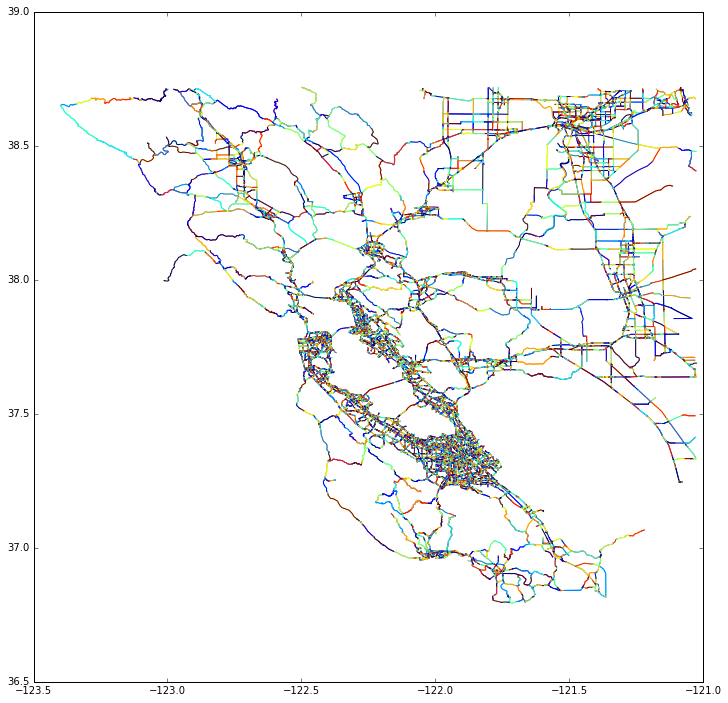

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

geojson_f ='resources/network/sf_secondary/network.geojson' 
fig, ax = plt.subplots(figsize=(12, 12))
gpd_network = gpd.read_file(geojson_f)
gpd_network.plot(ax=ax)